In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
SR=22050
N_MFCC=40
N_MELS=128
DURATION=1
SAMPLES_PER_TRACK=SR*DURATION
CLASSES=['AssaultRifle','MachineGun','Noise']

In [3]:
def extract_features(file_path):
    y,sr=librosa.load(file_path,sr=SR,duration=DURATION)
    if len(y)<SAMPLES_PER_TRACK:
        y=np.pad(y,(0,SAMPLES_PER_TRACK-len(y)))
    else:
        y=y[:SAMPLES_PER_TRACK]
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=N_MFCC)
    mfcc=librosa.util.fix_length(mfcc,size=174,axis=1)
    mfcc=mfcc[...,np.newaxis]
    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr)
    mel_spec=librosa.power_to_db(mel_spec,ref=np.max)
    # plt.figure(figsize=(10,6))
    # librosa.display.specshow(mel_spec,sr=SR,x_axis='time',y_axis='mel')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel-Spectogram')
    # plt.tight_layout()
    # plt.show()
    mel_spec=librosa.util.fix_length(mel_spec,size=174,axis=1)
    mel_spec=mel_spec[...,np.newaxis]
    return mfcc,mel_spec

In [4]:
# mfcc_ex,melspec_ex=extract_features('trimmed/MachineGun/4 (4).wav')

In [5]:
# melspec_ex = np.expand_dims(melspec_ex, axis=0)
# melspec_ex.shape

In [6]:
# mfcc_ex = np.expand_dims(mfcc_ex, axis=0)
# mfcc_ex.shape

In [7]:
def load_dataset(dataset_path):
    x_mfcc,x_melspec,y=[],[],[]
    for i,class_name in enumerate(CLASSES):
        class_dir=os.path.join(dataset_path,class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path=os.path.join(class_dir,file_name)
                mfcc,mel_spec=extract_features(file_path)
                x_mfcc.append(mfcc)
                x_melspec.append(mel_spec)
                y.append(i)
    x_mfcc=np.array(x_mfcc)
    x_melspec=np.array(x_melspec)
    y=to_categorical(y,num_classes=len(CLASSES))
    return x_mfcc,x_melspec,y


In [8]:
X_mfcc,X_melspec,y=load_dataset('new_dataset')

In [9]:
X_melspec.shape

(2252, 128, 174, 1)

In [10]:
X_mfcc.shape

(2252, 40, 174, 1)

In [11]:
X_mfcc_trainval, X_mfcc_test, X_melspec_trainval, X_melspec_test, y_trainval, y_test = train_test_split(
    X_mfcc, X_melspec, y, test_size=0.3, random_state=2
)

# Then, split the training+validation set into training and validation sets
X_mfcc_train, X_mfcc_val, X_melspec_train, X_melspec_val, y_train, y_val = train_test_split(
    X_mfcc_trainval, X_melspec_trainval, y_trainval, test_size=0.2, random_state=2
)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Input
from tensorflow.keras.models import Model
def create_model(input_shape_mfcc,input_shape_melspec,num_classes=3):
    input_mfcc=Input(shape=input_shape_mfcc,name='mfcc_input')
    x_mfcc=Conv2D(16,kernel_size=(3,3),activation='relu')(input_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(32,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(64,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(1,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=Conv2D(128,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=GlobalAveragePooling2D()(x_mfcc)

    input_melspec=Input(shape=input_shape_melspec,name='melspec_input')
    x_melspec=Conv2D(16,kernel_size=(3,3),activation='relu')(input_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(32,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(64,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(128,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec = GlobalAveragePooling2D()(x_melspec)

    concatenated=tf.keras.layers.concatenate([x_mfcc,x_melspec])
    output=Dense(128,activation='relu')(concatenated)
    output=Dense(num_classes,activation='softmax')(output)

    model=Model(inputs=[input_mfcc,input_melspec],outputs=output)
    return model

In [13]:
input_shape_mfcc=(40,174,1)
input_shape_melspec=(128,174,1)
model=create_model(input_shape_mfcc,input_shape_melspec,num_classes=3)


In [14]:
from tensorflow.keras.metrics import AUC
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision',AUC(),'Recall'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 40, 174,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ melspec_input       │ (None, 128, 174,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 172,   │        160 │ mfcc_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 172,  │        160 │ melspec_input[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 86,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 86,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 19, 86,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 63, 86,    │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 17, 84,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 84,    │      4,640 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 42, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 42,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 42, 32) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 42,    │          0 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 40, 64) │     18,496 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 40,    │     18,496 │ dropout_5[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 20, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 227,587 (889.01 KB)

 Trainable params: 227,587 (889.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
X_mfcc_test.shape

(676, 40, 174, 1)

Epoch 1/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - Precision: 0.6478 - Recall: 0.1108 - accuracy: 0.5521 - auc: 0.7263 - loss: 0.9923 - val_Precision: 0.8156 - val_Recall: 0.4620 - val_accuracy: 0.6962 - val_auc: 0.8425 - val_loss: 0.8087
Epoch 2/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - Precision: 0.7614 - Recall: 0.6644 - accuracy: 0.7268 - auc: 0.8475 - loss: 0.7521 - val_Precision: 0.7951 - val_Recall: 0.6139 - val_accuracy: 0.7405 - val_auc: 0.8867 - val_loss: 0.7296
Epoch 3/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - Precision: 0.7641 - Recall: 0.6847 - accuracy: 0.7432 - auc: 0.8752 - loss: 0.6820 - val_Precision: 0.8656 - val_Recall: 0.6930 - val_accuracy: 0.7785 - val_auc: 0.9238 - val_loss: 0.6043
Epoch 4/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - Precision: 0.7981 - Recall: 0.7284 - accuracy: 0.7785 - auc: 0.9006 - loss: 0.6061 - val_Precision: 0.8602 - val_Recall: 0.7595 - val_accuracy: 0.8196 - val_auc: 0.9324 - val_loss: 0.5412
Epoch 5/70
40/40 ━━━━━━━━━━━━━━━

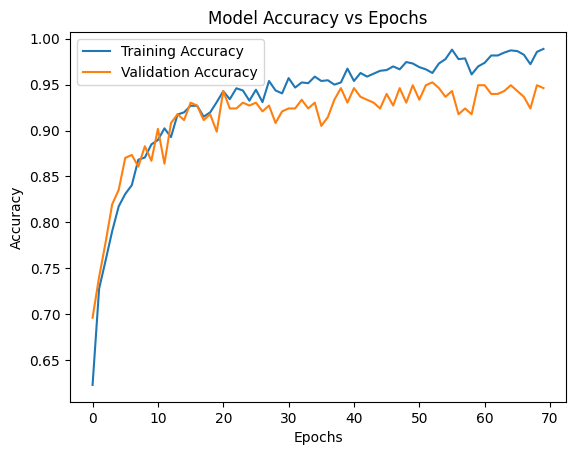

In [17]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_accuracy',save_best_only=True,mode='max')
history=model.fit([X_mfcc_train,X_melspec_train],y_train,validation_data=([X_mfcc_val,X_melspec_val],y_val),epochs=70,batch_size=32,callbacks=[checkpoint])
model.load_weights('best_model.keras')
results=model.evaluate([X_mfcc_test,X_melspec_test],y_test)
test_loss,test_accuracy=results[0],results[1]
print(f'Test Accuracy:{test_accuracy*100:.2f}%')
print(f'Test Loss:{test_loss*100:.2f}%')


#Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Adding labels and title
plt.title('Model Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

epochs = len(history.history['accuracy'])
plt.xticks(np.arange(0, epochs+1, 10))  # Scale of 10 on x-axis


# Display the plot
plt.show()

In [1]:
results

NameError: name 'results' is not defined

In [45]:
# predictions=model.predict([mfcc_ex,melspec_ex])
# predicted_class=np.argmax(predictions,axis=1)
# print(predicted_class[0])